In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from Bio import SeqIO

# Some basic functions

In [158]:
from multiprocessing.resource_sharer import stop


def genbank_seqio(gbkf, verbose=False):
    """
    Get the parser stream
    :param gbkf: genbank file
    :param verbose:
    :return:
    """

    handle = open(gbkf, 'r')

    return SeqIO.parse(handle, "genbank")

def get_features_of_type(seqio, ftype):
    """
    Get the features
    :param seqio:
    :param ftype:
    :return:
    """

    for seq in seqio:
        for feature in seq.features:
            if feature.type == ftype:
                yield feature

def get_features_of_type_rec(seqiorec, ftype):
    """
    Get the features
    :param seqiorec:
    :param ftype:
    :return:
    """

    for feature in seqiorec.features:
        if feature.type == ftype:
            yield feature

def GC(seq):
    """
    Calculate GC content1
    :param seq:
    :return:
    """

    gc = 0
    for i in seq:
        if i == 'G' or i == 'C':
            gc += 1
    return gc / len(seq)

def get_average_cds_length(seqio):
    """
    Get average CDS length
    :param seqio:
    :return:
    """

    cds_length = 0
    for seq in seqio:
        for feature in seq.features:
            if feature.type == 'CDS':
                cds_length += len(feature.location.extract(seq).seq)/3
    return cds_length / len(seqio)

def get_average_cds_length_rec(seqiorec):
    """
    Get average CDS length
    :param seqiorec:
    :return:
    """

    cds_length = 0
    for feature in seqiorec.features:
        if feature.type == 'CDS':
            cds_length += len(feature.location.extract(seqiorec).seq)/3
    return cds_length / len(seqiorec.features)

def get_median_cds_length(seqio):
    """
    Get median CDS length
    :param seqio:
    :return:
    """

    cds_length = []
    for seq in seqio:
        for feature in seq.features:
            if feature.type == 'CDS':
                cds_length.append(len(feature.location.extract(seq).seq)/3)
    return np.median(cds_length)

def get_median_cds_length_rec(seqiorec):
    """
    Get median CDS length
    :param seqiorec:
    :return:
    """

    cds_length = []
    for feature in seqiorec.features:
        if feature.type == 'CDS':
            cds_length.append(len(feature.location.extract(seqiorec).seq)/3)
    return np.median(cds_length)

def get_coding_density_rec(seqiorec, ftypes=['CDS']):
    """
    Get coding density for a single record
    :param seqio:
    :param ftypes:
    :return:
    """

    cdcov = np.zeros(len(seqiorec.seq))
    for feature in seqiorec.features:
        if feature.type in ftypes:
            start, stop = map(int, sorted([feature.location.start, feature.location.end]))
            cdcov[start:stop] += 1
    return sum([1 if x > 0 else 0 for x in cdcov]) / len(seqiorec.seq)

def get_distribution_of_stops(seqiorec, window=210, step=1):
    """
    Get distribution of stops
    :param seqiorec:
    :param window:
    :param step:
    :return:
    """

    stops = ['TAA', 'TAG', 'TGA']

    stops_distr = {
        'x': range(1, len(seqiorec.seq) + 1),
        'TAA': [np.NAN]*int(window/2),
        'TAG': [np.NAN]*int(window/2),
        'TGA': [np.NAN]*int(window/2)
    }
    
    i = 0
    while i + window/2 + 1 <= len(seqiorec.seq) - window/2:
        window_seq = seqiorec.seq[i : i + window]
        taa = window_seq.count('TAA')
        tag = window_seq.count('TAG')
        tga = window_seq.count('TGA')
        stops_distr['TAA'].extend([taa]*(step))
        stops_distr['TAG'].extend([tag]*(step))
        stops_distr['TGA'].extend([tga]*(step))
        i += step
        
    i -= step
    left = len(seqiorec.seq) - len(stops_distr['TAA'])
    if left > 0:   
        stops_distr['TAA'].extend([np.NAN]*left)
        stops_distr['TAG'].extend([np.NAN]*left)
        stops_distr['TGA'].extend([np.NAN]*left)

    return pd.DataFrame(stops_distr)




# Testing functions above

In [59]:
infiles = glob.glob('./genbank/UAG-readthrough_crAss_clade_sp._strain_cr150_1*.gbk')

# for infile in infiles:
#     print("=== Working on file {} ===".format(infile))
#     for record in genbank_seqio(infile):
#         print("Stats for {} ({} bp)".format(record.id, len(record.seq)))
#         print("GC content: {}".format(GC(record.seq)))
#         print("Number of CDS: {}".format(len(list(get_features_of_type_rec(record, 'CDS')))))
#         print("Average CDS length: {}".format(get_average_cds_length_rec(record)))
#         print("Median CDS length: {}".format(get_median_cds_length_rec(record)))
#         print("Average coding density: {}".format(get_coding_density_rec(record, ['CDS', 'tRNA'])))
#         df = get_distribution_of_stops(record, window=210, step=1)

for infile in infiles:
    print("=== Working on file {} ===".format(infile))
    for record in genbank_seqio(infile):
        print("Average coding density: {}".format(get_coding_density_rec(record, ['CDS', 'tRNA'])))

=== Working on file ./genbank/GCA_002135175.2-subset-TAA.gbk ===
Average coding density: 0.95338
=== Working on file ./genbank/GCA_002135175.2-subset-TAG-TAA.gbk ===
Average coding density: 0.94241
=== Working on file ./genbank/GCA_002135175.2-subset-TAG-TGA-TAA.gbk ===
Average coding density: 0.79723
=== Working on file ./genbank/GCA_002135175.2-subset-TAG-TGA.gbk ===
Average coding density: 0.88946
=== Working on file ./genbank/GCA_002135175.2-subset-TAG.gbk ===
Average coding density: 0.98071
=== Working on file ./genbank/GCA_002135175.2-subset-TGA-TAA.gbk ===
Average coding density: 0.83016
=== Working on file ./genbank/GCA_002135175.2-subset-TGA.gbk ===
Average coding density: 0.92381


/home/dec/miniconda3/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:1555: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       CP022928.1:1-100000    100000 bp    DNA             PHG\n'
  warnings.warn(


# Visualise function

In [74]:
def visualise(df, length, labels):

    """
    df: dataframe
    length: length of genomes
    lables: lables of stats
    """

    axes = df.plot.line(subplots=True, figsize=(16, 8), legend=False)

    for i in range(len(axes)):
        axes[i].set_xlim(0, length)
        axes[i].yaxis.grid()
        axes[i].set_axisbelow(True)
        axes[i].set(ylabel=labels[i])

/home/dec/miniconda3/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:1555: BiopythonParserWarning: Malformed LOCUS line found - is this correct?
:'LOCUS       MZ130495.1    101130 bp    DNA             PHG\n'
  warnings.warn(


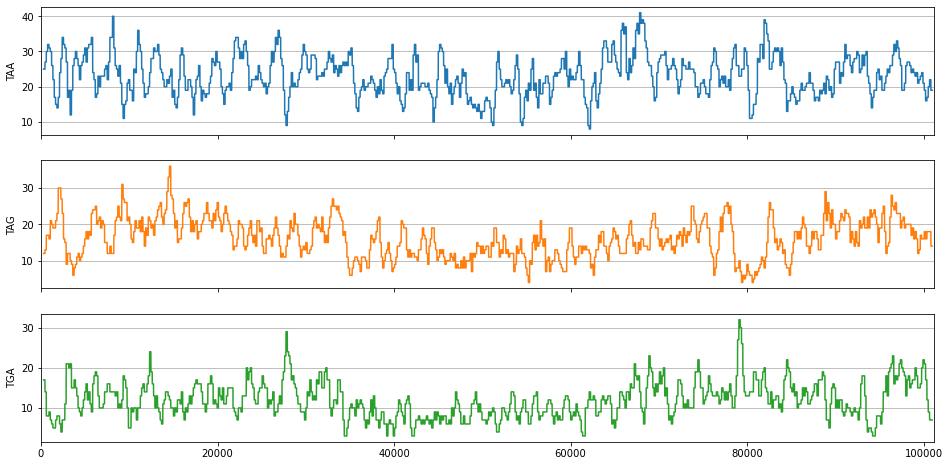

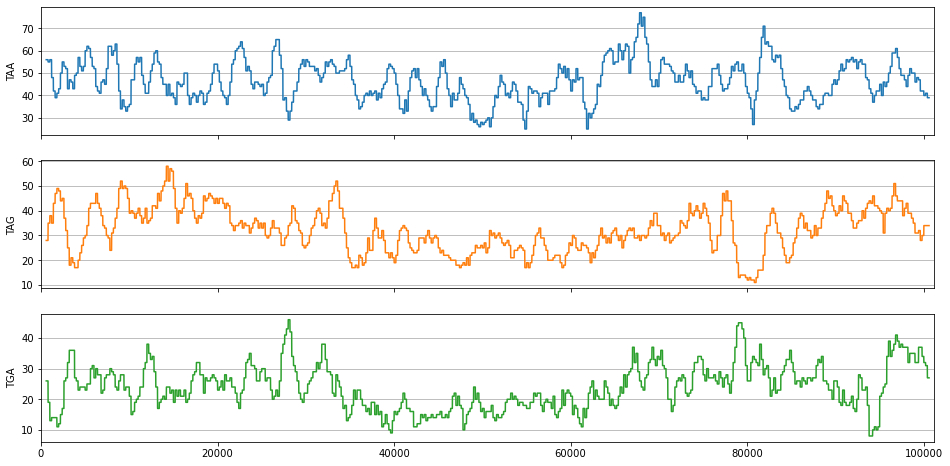

In [160]:
infiles = glob.glob('./genbank/UAG-readthrough_crAss_clade_sp._strain_cr150_1*.gbk')
record = list(genbank_seqio(infiles[0]))[0]
df = get_distribution_of_stops(record, window=600, step=150)
# print(df.head(150))
visualise(df.drop(['x'], axis=1), length=len(df['x']), labels=['TAA', 'TAG', 'TGA'])
df = get_distribution_of_stops(record, window=1200, step=200)
visualise(df.drop(['x'], axis=1), length=len(df['x']), labels=['TAA', 'TAG', 'TGA'])